In [1]:
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from os import listdir
import timeit
from collections import defaultdict


In [2]:
%load_ext autoreload
%autoreload 2
from scripts import *

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=5)

In [4]:
lfw_people.images.shape

(3023, 625, 470)

In [5]:
lfw_people.images.__sizeof__() * 1e-7

355.2025144

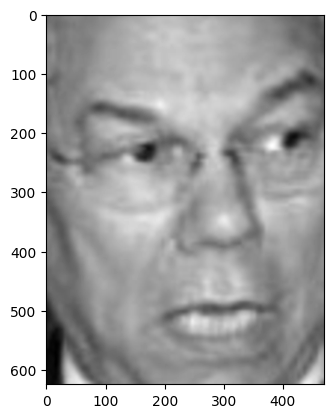

In [6]:
plt.imshow(lfw_people.images[5],cmap='gray')
plt.show()

In [149]:
np.unique(lfw_people.target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], dtype=int64)

In [7]:
def predict(data, labels, target, k):
    '''ранжирует k первых категорий по расстоянию и берет наиболее частую'''
    target_vector = target.flatten(order='F')

    distances = []
    for i in range(data.shape[0]):
        database_vector = data[i, :, :].flatten(order='F')
        database_label = labels[i]
        distances.append((np.linalg.norm(target_vector - database_vector), database_label))

    sorted_distances = sorted(distances, key=lambda vals: vals[0])
    k_labels = [label for (_, label) in sorted_distances[:k]]
    #print(k_labels)
    return find_majority(k_labels)

In [10]:
target = lfw_people.images[0, :, :]

In [9]:
predict(lfw_people.images[1:, :, :], lfw_people.target[1:], target, 1)

58

In [12]:
lfw_people.images.shape[0] / 100

30.23

Время и память по количеству фото

In [12]:
times_naive_n_p = []
step = 302
for i in range(1, 10):
    time = %timeit -n1 -o -q predict(lfw_people.images[1:step * i, :, :], lfw_people.target[1:], target, 1)
    times_naive_n_p.append(time.average)

In [13]:
storage_naive_n_p = []
for i in range(1, 10):
    storage = lfw_people.images[1:step * i, :, :].copy()
    storage_naive_n_p.append(storage.__sizeof__() * 1e-7)

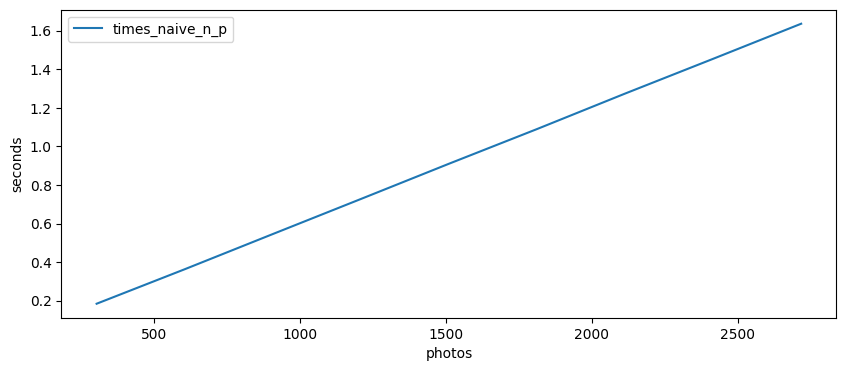

In [15]:
mosaic = '''
QQQ
'''
sizes = [302 * i for i in range(1, 10)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
ax['Q'].plot(sizes, times_naive_n_p, label = "times_naive_n_p")
#ax['Q'].plot(sizes, storage_naive, label = "storage_naive")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

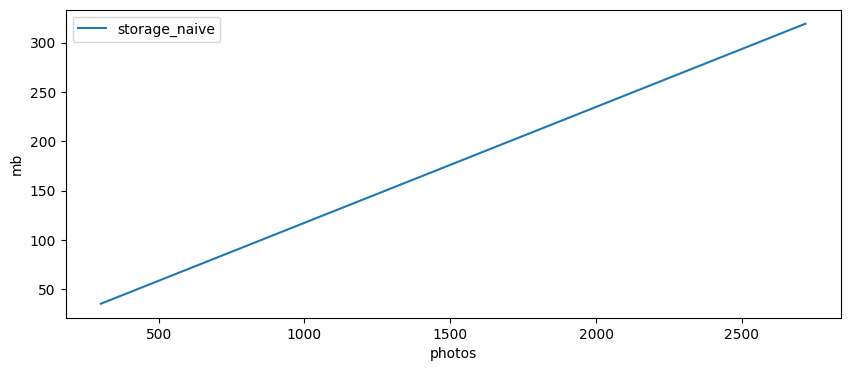

In [16]:
mosaic = '''
QQQ
'''
sizes = [302 * i for i in range(1, 10)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
#ax['Q'].plot(sizes, times_naive, label = "times_naive")
ax['Q'].plot(sizes, storage_naive_n_p, label = "storage_naive")
ax['Q'].set_ylabel('mb', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

Время и память по количество людей в БД

In [17]:
times_naive = []
storage_naive = []
for i in range(1, 11):
    time = %timeit -n1 -o -q predict(lfw_people.images[lfw_people.target < int(i * 6), :, :], lfw_people.target[lfw_people.target < int(i * 6)], target, 1)
    times_naive.append(time.average)
    storage = lfw_people.images[lfw_people.target < int(i * 6), :, :].copy()
    storage_naive.append(storage.__sizeof__() * 1e-7)

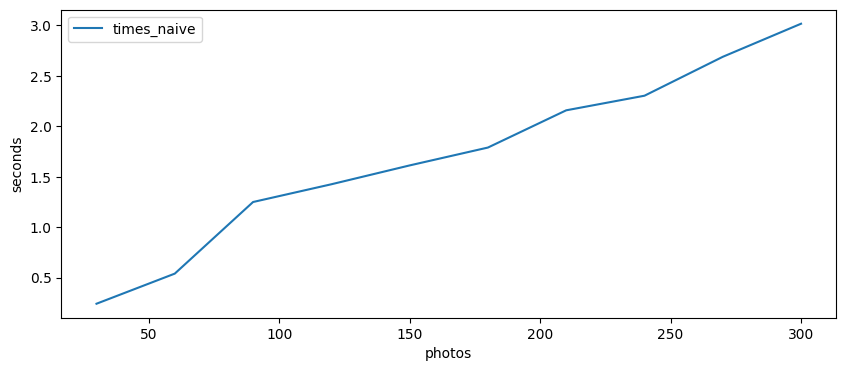

In [18]:
mosaic = '''
QQQ
'''
sizes = [30 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
ax['Q'].plot(sizes, times_naive, label = "times_naive")
#ax['Q'].plot(sizes, storage_naive, label = "storage_naive")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

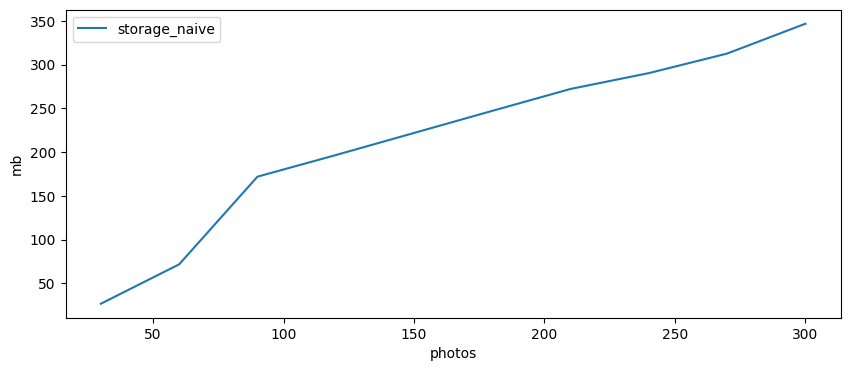

In [19]:
mosaic = '''
QQQ
'''
sizes = [30 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
#ax['Q'].plot(sizes, times_naive, label = "times_naive")
ax['Q'].plot(sizes, storage_naive, label = "storage_naive")
ax['Q'].set_ylabel('mb', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

In [43]:
len(np.unique(lfw_people.target))

62

In [20]:
mean_dataset = np.zeros((lfw_people.images.shape[1],lfw_people.images.shape[2] , len(np.unique(lfw_people.target))))
for i in range(lfw_people.images.shape[0]):
    mean_dataset[:, :, lfw_people.target[i]] += lfw_people.images[i]
for i in range(len(np.unique(lfw_people.target))):
    mean_dataset[:, :, i] = mean_dataset[:, :, i] / len(lfw_people.target[lfw_people.target == i])

In [21]:
mean_dataset.shape

(625, 470, 62)

In [22]:
for i in range(lfw_people.images.shape[0]):
    mean_dataset[:, :, lfw_people.target[i]] += lfw_people.images[i]

In [23]:
for i in range(len(np.unique(lfw_people.target))):
    mean_dataset[:, :, i] = mean_dataset[:, :, i] / len(lfw_people.target[lfw_people.target == i])

In [24]:
mean_dataset.__sizeof__() * 1e-7

14.5700144

In [25]:
def predict(data, labels, target, k):
    '''ранжирует k первых категорий по расстоянию и берет наиболее частую'''
    target_vector = target.flatten(order='F')

    distances = []
    for i in range(data.shape[2]):
        database_vector = data[:, :, i].flatten(order='F')
        database_label = labels[i]
        distances.append((np.linalg.norm(target_vector - database_vector), database_label))

    sorted_distances = sorted(distances, key=lambda vals: vals[0])
    k_labels = [label for (_, label) in sorted_distances[:k]]
    #print(k_labels)
    return find_majority(k_labels)

In [26]:
target = lfw_people.images[20, :, :]

In [27]:
predict(mean_dataset, np.unique(lfw_people.target), target, 1)

51

Время и память Л2 усредненных по количеству людей в БД

In [28]:
times_mean = []
storage_mean = []
step = 302
for k in range(1, 11):
    dataset = lfw_people.images[lfw_people.target < int(k * 6), :, :]
    targets = lfw_people.target[lfw_people.target < int(k * 6)]
    
    mean_dataset = np.zeros((dataset.shape[1],dataset.shape[2] , len(np.unique(targets))))
    for i in range(dataset.shape[0]):
        mean_dataset[:, :, targets[i]] += dataset[i]
    for i in range(len(np.unique(targets))):
        mean_dataset[:, :, i] = mean_dataset[:, :, i] / (len(targets[targets == i]))
    time = %timeit -n1 -o -q predict(mean_dataset, np.unique(targets), target, 1)
    times_mean.append(time.average)
    storage_mean.append(mean_dataset.__sizeof__() * 1e-7)

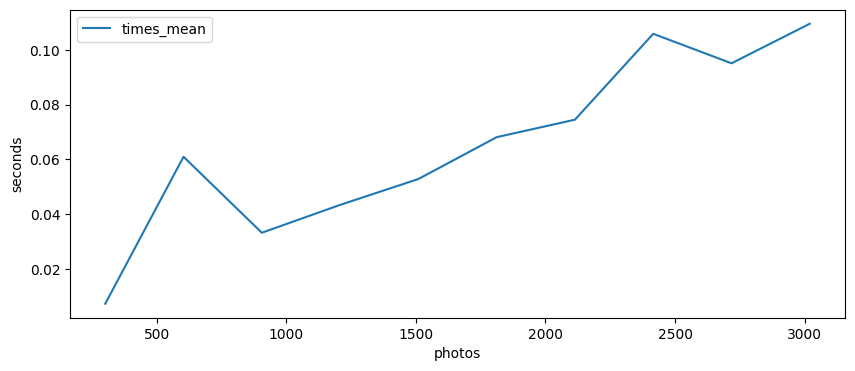

In [29]:
mosaic = '''
QQQ
'''
sizes = [302 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
ax['Q'].plot(sizes, times_mean, label = "times_mean")
#ax['Q'].plot(sizes, storage_naive, label = "storage_naive")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

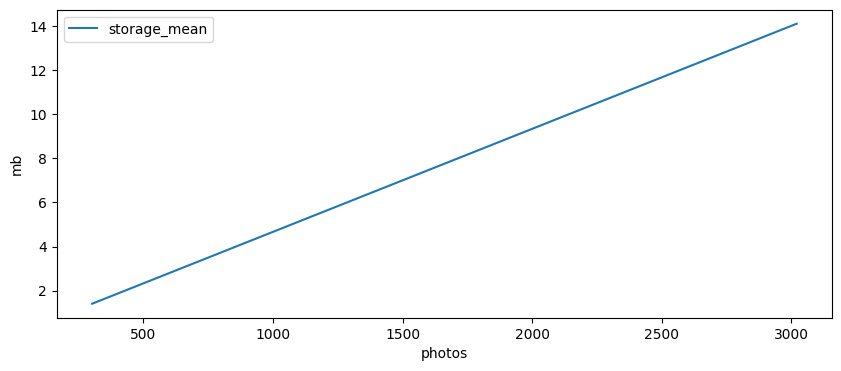

In [30]:
mosaic = '''
QQQ
'''
#storage_mean = [14.57] * 9
sizes = [302 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
#ax['Q'].plot(sizes, times_naive, label = "times_naive")
ax['Q'].plot(sizes, storage_mean, label = "storage_mean")
ax['Q'].set_ylabel('mb', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

Время и память СВД по количеству фото

In [53]:
times_svd_n_p = []
storage_svd_n_p = []
for k in range(1, 10):
    dataset_batch = lfw_people.images[1:step * k, :, :]
    targets = lfw_people.target[1:step * k]

    dataset = np.zeros((lfw_people.images.shape[2] * lfw_people.images.shape[1], 20, len(np.unique(lfw_people.target))))
    counter = {}

    for i in range(1, dataset_batch.shape[0]):
        if targets[i] not in counter:
            counter[targets[i]] = 0
        elif counter[targets[i]] > 18:
            continue
        else:
            counter[targets[i]] += 1

        dataset[:, counter[targets[i]], targets[i]] = dataset_batch[i].flatten(order='F')

    U_data = np.zeros(dataset.shape)
    for i in range(dataset.shape[2]):
        U, S, Vh = np.linalg.svd(dataset[:, :, i], full_matrices=False)
        U_data[:, :20, i] = U[:, :20].copy()
    m=1
    U_data = U_data[:, :5, :].copy()
    labels = np.arange(U_data.shape[2])
    target = dataset_batch[m, :, :]
    target = target.flatten(order='F')
    label = targets[m]
    time = %timeit -n1 -o -q predict_svd(U_data, labels, target, 1)
    times_svd_n_p.append(time.average)
    storage_svd_n_p.append(U_data.__sizeof__() * 1e-7)


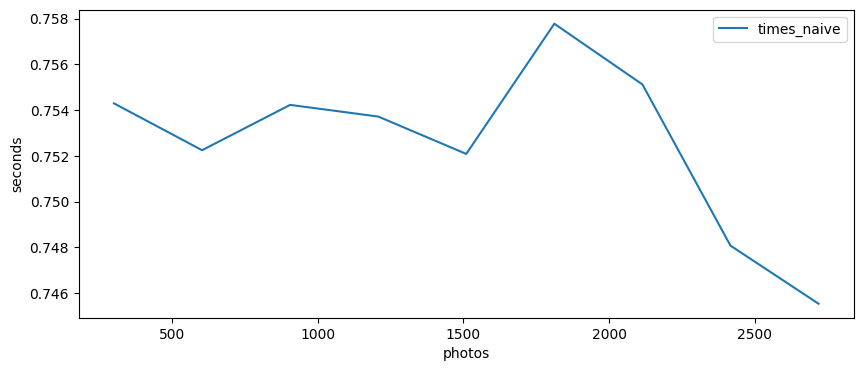

In [54]:
mosaic = '''
QQQ
'''
sizes = [302 * i for i in range(1, 10)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
ax['Q'].plot(sizes, times_svd_n_p, label = "times_naive")
#ax['Q'].plot(sizes, storage_naive, label = "storage_naive")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

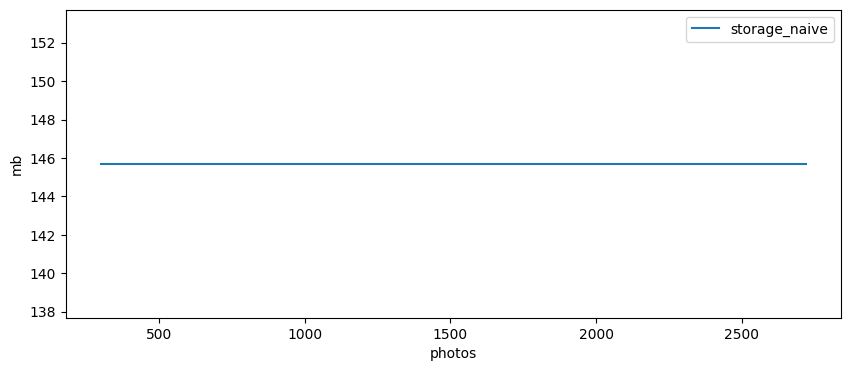

In [36]:
mosaic = '''
QQQ
'''

sizes = [302 * i for i in range(1, 10)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
#ax['Q'].plot(sizes, times_naive, label = "times_naive")
ax['Q'].plot(sizes, storage_svd_n_p, label = "storage_naive")
ax['Q'].set_ylabel('mb', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

Время и память СВД по количеству людей в БД

In [37]:
times_svd = []
storage_svd = []
for k in range(1, 11):
    dataset_batch = lfw_people.images[lfw_people.target < int(k * 6), :, :]
    targets = lfw_people.target[lfw_people.target < int(k * 6)]
    
    dataset = np.zeros((lfw_people.images.shape[2] * lfw_people.images.shape[1], 20, len(np.unique(targets))))
    counter = {}
    
    for i in range(1, dataset_batch.shape[0]):
        if targets[i] not in counter:
            counter[targets[i]] = 0
        elif counter[targets[i]] > 18:
            continue
        else:
            counter[targets[i]] += 1
    
        dataset[:, counter[targets[i]], targets[i]] = dataset_batch[i].flatten(order='F')

    U_data = np.zeros(dataset.shape)
    for i in range(dataset.shape[2]):
        U, S, Vh = np.linalg.svd(dataset[:, :, i], full_matrices=False)
        U_data[:, :20, i] = U[:, :20].copy()
    m=1
    U_data = U_data[:, :10, :].copy()
    labels = np.arange(U_data.shape[2])
    target = dataset_batch[m, :, :]
    target = target.flatten(order='F')
    label = targets[m]
    time = %timeit -n1 -o -q predict_svd(U_data, labels, target, 1)
    times_svd.append(time.average)
    storage_svd.append(U_data.__sizeof__() * 1e-7)


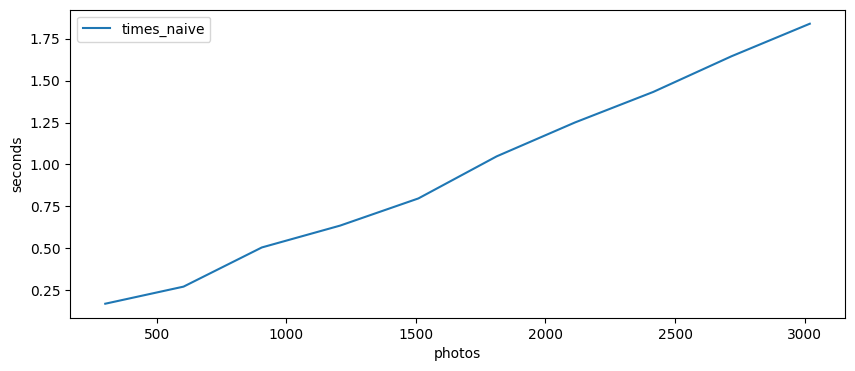

In [38]:
mosaic = '''
QQQ
'''
sizes = [302 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
ax['Q'].plot(sizes, times_svd, label = "times_naive")
#ax['Q'].plot(sizes, storage_naive, label = "storage_naive")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

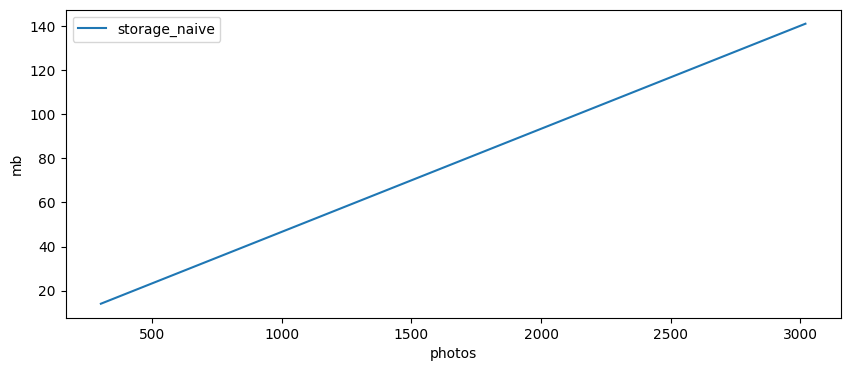

In [39]:
mosaic = '''
QQQ
'''
storage_mean = [14.57] * 9
sizes = [302 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
#ax['Q'].plot(sizes, times_naive, label = "times_naive")
ax['Q'].plot(sizes, storage_svd, label = "storage_naive")
ax['Q'].set_ylabel('mb', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

In [4]:
dataset = np.zeros((lfw_people.images.shape[2] * lfw_people.images.shape[1], 20, len(np.unique(lfw_people.target))))
counter = {}

for i in range(1, lfw_people.images.shape[0]):
    if lfw_people.target[i] not in counter:
        counter[lfw_people.target[i]] = 0
    elif counter[lfw_people.target[i]] > 48:
        continue
    else:
        counter[lfw_people.target[i]] += 1

    dataset[:, counter[lfw_people.target[i]], lfw_people.target[i]] = lfw_people.images[i].flatten(order='F')


    

In [20]:
U_data = np.zeros(dataset.shape)
for i in range(dataset.shape[2]):
    U, S, Vh = np.linalg.svd(dataset[:, :, i], full_matrices=False)
    U_data[:, :20, i] = U[:, :20]

In [221]:
U_data = U_data[:, :10, :]

In [32]:
def predict_svd(data, labels, target, k):
    '''
    ранжирует k первых категорий по расстоянию и берет наиболее частую
    '''

    target_vector = target

    norm_target = np.linalg.norm(target_vector)

    distances = []
    for i in range(data.shape[2]):
        database_matrix = data[:, :, i]
        database_label = labels[i]
        distances.append((np.linalg.norm((target_vector - database_matrix @ (database_matrix.T @ target_vector)) / norm_target), database_label))

    sorted_distances = sorted(distances, key=lambda vals: vals[0])
    k_labels = [label for (_, label) in sorted_distances[:k]]
    #print(k_labels)
    return find_majority(k_labels)

In [11]:
m = 11
labels = np.arange(U_data.shape[2])
target = lfw_people.images[m, :, :]
target = target.flatten(order='F')
lfw_people.target[m]

14

In [12]:
indices = np.arange(lfw_people.images.shape[0])
np.random.shuffle(indices)

In [223]:
counter = 0
for k in range(100):
    i = indices[k]
    target = lfw_people.images[i, :, :].flatten(order='F')
    label = lfw_people.target[i]
    result = predict_svd(U_data, labels, target, 1)
    if result == label:
        counter += 1
print(counter / 100)

0.65


In [225]:
U_data = U_data[:, :7, :]

In [226]:
counter = 0
for k in range(100):
    i = indices[k]
    target = lfw_people.images[i, :, :].flatten(order='F')
    label = lfw_people.target[i]
    result = predict_svd(U_data, labels, target, 1)
    if result == label:
        counter += 1
print(counter / 100)

0.65


большинство данных в U

In [ ]:
dataset = np.zeros((lfw_people.images.shape[2] * lfw_people.images.shape[1], 50, len(np.unique(lfw_people.target))))
counter = {}

for i in range(1, lfw_people.images.shape[0]):
    if lfw_people.target[i] not in counter:
        counter[lfw_people.target[i]] = 0
    elif counter[lfw_people.target[i]] > 48:
        continue
    else:
        counter[lfw_people.target[i]] += 1

    dataset[:, counter[lfw_people.target[i]], lfw_people.target[i]] = lfw_people.images[i].flatten(order='F')


In [ ]:
U_data = np.zeros(dataset.shape)
for i in range(dataset.shape[2]):
    U, S, Vh = np.linalg.svd(dataset[:, :, i], full_matrices=False)
    U_data[:, :20, i] = U[:, :20]

In [21]:
U_data = U_data[:, :20, :]

In [23]:
counter = 0
for k in range(100):
    i = indices[k]
    target = lfw_people.images[i, :, :].flatten(order='F')
    label = lfw_people.target[i]
    result = predict_svd(U_data, labels, target, 1)
    if result == label:
        counter += 1
print(counter / 100)

0.85


In [14]:
U_data = U_data[:, :10, :]

In [16]:
counter = 0
for k in range(100):
    i = indices[k]
    target = lfw_people.images[i, :, :].flatten(order='F')
    label = lfw_people.target[i]
    result = predict_svd(U_data, labels, target, 1)
    if result == label:
        counter += 1
print(counter / 100)

0.82


In [17]:
U_data = U_data[:, :7, :]

In [18]:
counter = 0
for k in range(100):
    i = indices[k]
    target = lfw_people.images[i, :, :].flatten(order='F')
    label = lfw_people.target[i]
    result = predict_svd(U_data, labels, target, 1)
    if result == label:
        counter += 1
print(counter / 100)

0.75


In [27]:
len(times_naive)

10

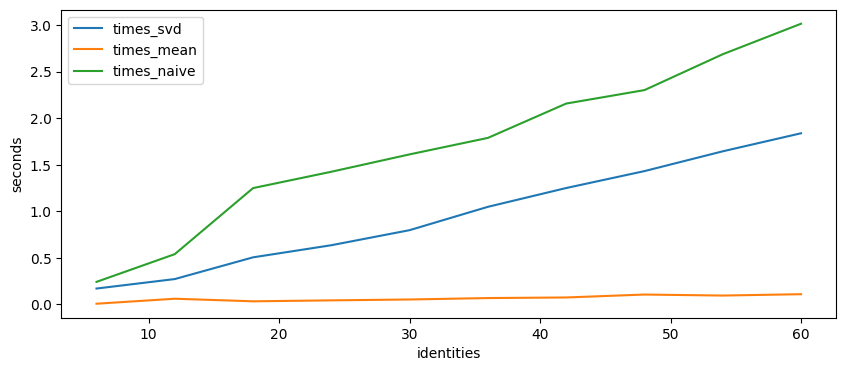

In [40]:
mosaic = '''
QQQ
'''
sizes = [6 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
ax['Q'].plot(sizes, times_svd, label = "times_svd")
ax['Q'].plot(sizes, times_mean, label = "times_mean")
ax['Q'].plot(sizes, times_naive, label = "times_naive")

ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('identities', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

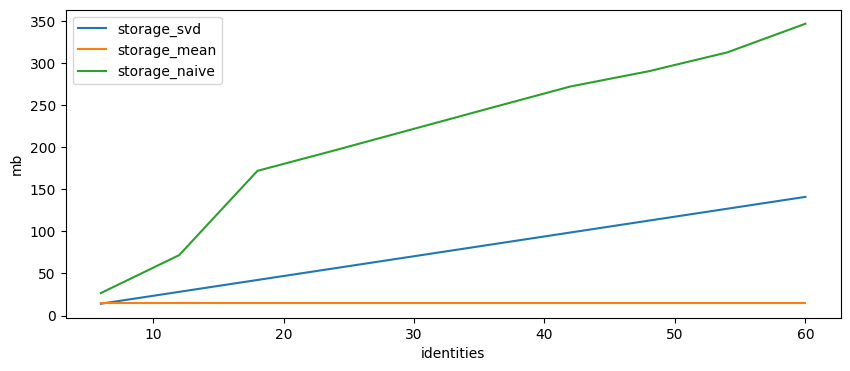

In [51]:
mosaic = '''
QQQ
'''

sizes = [6 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
#ax['Q'].plot(sizes, times_naive, label = "times_naive")
ax['Q'].plot(sizes, storage_svd, label = "storage_svd")
ax['Q'].plot(sizes, storage_mean, label = "storage_mean")
ax['Q'].plot(sizes, storage_naive, label = "storage_naive")
ax['Q'].set_ylabel('mb', fontsize=10)
ax['Q'].set_xlabel('identities', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

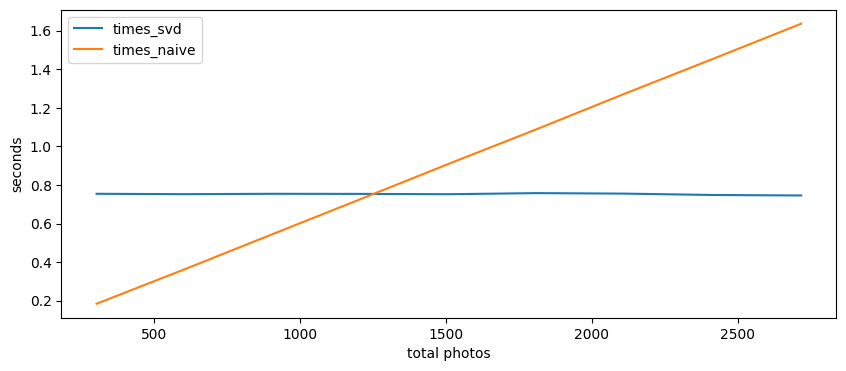

In [57]:
mosaic = '''
QQQ
'''
sizes = [302 * i for i in range(1, 10)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
ax['Q'].plot(sizes, times_svd_n_p, label = "times_svd")
#ax['Q'].plot(sizes, times_mean_n_p, label = "times_mean")
ax['Q'].plot(sizes, times_naive_n_p, label = "times_naive")

ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('total photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()